# Example notebook: Different ROC formulations

In this notebook we demonstrate how to use the different ROC formulations for a basic portfolio optimization problem.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dwave.samplers import SimulatedAnnealingSampler
import json
from pathlib import Path
from tno.quantum.problems.portfolio_optimization import (
    PortfolioOptimizer,
    plot_front,
    plot_points,
)

## Load benchmark data

In [2]:
# Load benchmark data and classical Pareto front solutions
with Path("classical_solutions_for_benchmark_dataset.json").open(
    encoding="utf-8"
) as json_file:
    json_data = json.load(json_file)

    # Reconstruct portfolio data
    portfolio_data = pd.DataFrame(
        data=json_data["portfolio_data"]["data"],
        columns=json_data["portfolio_data"]["columns"],
    )

    # Reconstruct classical Pareto frontier solutions
    x1_classical = json_data["classical_solution"]["constrained"]["x"]
    y1_classical = json_data["classical_solution"]["constrained"]["y"]

portfolio_data.head()

,asset,outstanding_now,min_outstanding_future,max_outstanding_future,emis_intens_now,emis_intens_future,income_now,regcap_now
0,Sector 1 - Country 1,10.2,14,19,10.0,7.6,5,5
1,Sector 2 - Country 1,600.0,473,528,80.0,60.8,70,40
2,Sector 3 - Country 1,20.0,24,28,30.0,22.8,5,10
3,Sector 4 - Country 1,800.0,1090,1410,5.0,3.8,1,2
4,Sector 5 - Country 1,40.0,56,74,5.0,3.8,10,5


In [3]:
# Choose QUBO sampler
sampler = SimulatedAnnealingSampler()
sampler_kwargs = {"num_reads": 20, "num_sweeps": 200}

# Set up penalty coefficients for the constraints
lambdas1 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas2 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas3 = np.logspace(-11, -9.5, 12, endpoint=False, base=10.0)
lambdas4 = np.array([1])

## Portfolio optimization problem using ROC formulation 1.

In [4]:
# Define the portfolio optimization problem
portfolio_optimizer_roc1 = PortfolioOptimizer(portfolio_data="benchmark_dataset", k=2)
portfolio_optimizer_roc1.add_minimize_hhi(weights=lambdas1)
portfolio_optimizer_roc1.add_maximize_roc(formulation=1, weights_roc=lambdas2)
portfolio_optimizer_roc1.add_emission_constraint(
    weights=lambdas4,
    emission_now="emis_intens_now",
    emission_future="emis_intens_future",
    name="emission",
)

In [5]:
# Solve the portfolio optimization problem for ROC1
results_roc1 = portfolio_optimizer_roc1.run(sampler, sampler_kwargs)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:25<00:00, 24.75it/s]


Drop duplicate samples in results.
Number of unique samples:  12500
Time consumed: 0:00:25.286351


## Portfolio optimization problem using ROC formulation 2.

In [6]:
# Define the portfolio optimization problem
portfolio_optimizer_roc2 = PortfolioOptimizer(portfolio_data="benchmark_dataset", k=2)
portfolio_optimizer_roc2.add_minimize_hhi(weights=lambdas1)
portfolio_optimizer_roc2.add_maximize_roc(
    formulation=2,
    ancilla_variables=3,
    weights_roc=lambdas2,
    weights_stabilize=lambdas3,
)
portfolio_optimizer_roc2.add_emission_constraint(
    weights=lambdas4,
    emission_now="emis_intens_now",
    emission_future="emis_intens_future",
    name="emission",
)

In [7]:
# Solve the portfolio optimization problem for ROC1
results_roc2 = portfolio_optimizer_roc2.run(sampler, sampler_kwargs)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [12:55<00:00,  9.67it/s]


Drop duplicate samples in results.
Number of unique samples:  150000
Time consumed: 0:12:56.233983


## Visualize results

In [9]:
# Plot results
x1, y1 = results_roc1.results_df["diff diversification"], results_roc1.results_df["diff ROC"]
x2, y2 = results_roc2.results_df["diff diversification"], results_roc2.results_df["diff ROC"]

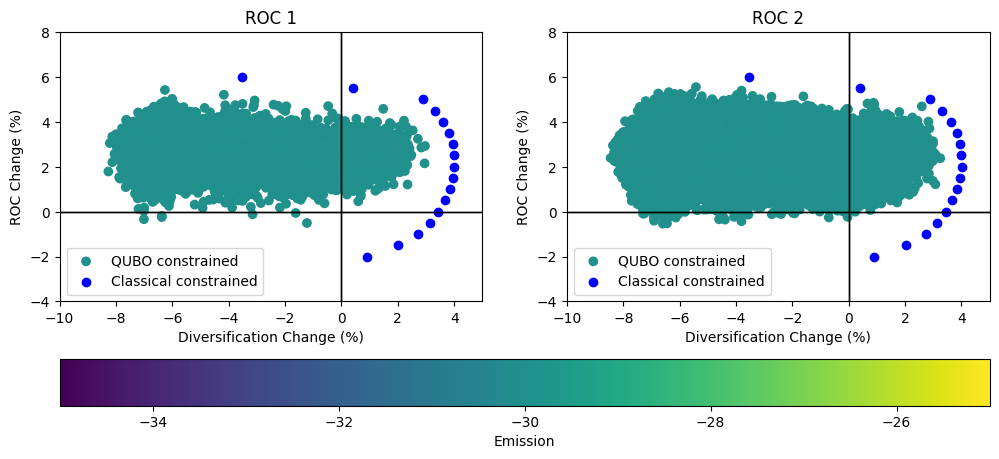

In [10]:
# Plot data points
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
(ax1, ax2) = axs
scatter1 = plot_points(
    x1, y1, ax=ax1, c=results_roc1.results_df["diff emission"], cmap="viridis", vmin=-35, vmax=-25, label="QUBO constrained"
)
scatter2 = plot_points(
    x2, y2, ax=ax2, c=results_roc2.results_df["diff emission"], cmap="viridis", vmin=-35, vmax=-25, label="QUBO constrained"
)
ax1.set_title("ROC 1")
ax2.set_title("ROC 2")
cbar = fig.colorbar(scatter2, ax=axs, orientation="horizontal", label="Emission")

for ax in axs:
    plot_points(x1_classical, y1_classical, color="blue", label="Classical constrained", ax=ax)
    ax.set_xlim(-10, 5)
    ax.set_ylim(-4, 8)